# BP domain adaptation of pre-trained agents for modified CartPole environments

In [11]:
import os
from datetime import date

import numpy as np
import torch
import torch.optim as optim
import random
import gym
import matplotlib.pyplot as plt
from copy import deepcopy

from cartpole_stuff.src.utils import evaluate_policy, rstdp_train_cartpole, evaluate_BP_policy

import site
site.addsitedir('../src/')

from cartpole_stuff.src.dsnn import RSTDPNet
from backpropamine_DQN import RNetwork

%matplotlib inline

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype = torch.float

In [13]:
# Environment specific parameters
env_name = 'CartPole-v0'
max_reward = 200
max_steps = 200

n_evaluations = 100
rstdp_episodes = 250

In [14]:
# Create environments
original_env = gym.make(env_name)

# modified_env = gym.make(env_name)
# modified_env.unwrapped.length *= 1.1

In [15]:
# SNN Hyperparameters
simulation_time = 8
alpha = 0.8
beta = 0.8
threshold = 0.5
weight_scale = 1
architecture = [4, 64, 64, 2]

In [16]:
# RSTDP Hyperparameters
tau = 5
tau_e = 10
C = 0.01
# A+/- are calculated from the pre-trained network weights

In [17]:
evaluation_seeds = np.load('cartpole_stuff/seeds/evaluation_seeds.npy')
rstdp_seeds = np.load('cartpole_stuff/seeds/rstdp_training_seeds.npy')

In [18]:
# Load pre-trained model weights
weights_0 = torch.load('simple_BP_DQRNN_training_650eps/checkpoint_DQN_0.pt', map_location=torch.device(device))
weights_1 = torch.load('simple_BP_DQRNN_training_650eps/checkpoint_DQN_1.pt', map_location=torch.device(device))
weights_2 = torch.load('simple_BP_DQRNN_training_650eps/checkpoint_DQN_2.pt', map_location=torch.device(device))
weights_3 = torch.load('simple_BP_DQRNN_training_650eps/checkpoint_DQN_3.pt', map_location=torch.device(device))
weights_4 = torch.load('simple_BP_DQRNN_training_650eps/checkpoint_DQN_4.pt', map_location=torch.device(device))
weights = [weights_0, weights_1, weights_2, weights_3, weights_4]


In [19]:
# Helper for printing
eraser = '\b \b'

### Evaluate pre-trained BP models on original environment

In [20]:
original_eval_rewards = []

for i, w in enumerate(weights):
    print('Run {:02d} ...'.format(i), end='')
    policy_net = RNetwork(4, 64, 2, 5).to(device)
    policy_net.loadWeights(w)

    rewards = evaluate_BP_policy(policy_net, original_env, n_evaluations, evaluation_seeds)
    original_eval_rewards.append(rewards)
    
    print(eraser*3 + '-> Avg reward: {:7.2f}'.format(np.mean(rewards)))

print(f"Mean avg reward: {np.mean(original_eval_rewards)}")

Run 00 ...

-> Avg reward:  168.11
Run 01 -> Avg reward:  194.24
Run 02 -> Avg reward:  200.00
Run 03 -> Avg reward:  193.33
Run 04 -> Avg reward:  199.82
Mean avg reward: 191.1


### Evaluate pre-trained BP models on modified environments

In [21]:
percentages = np.linspace(1.1, 2.0, 10)
all_modified_env_eval_rewards = []
for percentage in percentages:

    modified_env = gym.make(env_name)
    modified_env.unwrapped.length *= percentage

    modified_env_eval_rewards = []

    for i, w in enumerate(weights):
        print('Run {:02d} ...'.format(i), end='')
        policy_net = RNetwork(4, 64, 2, 5).to(device)
        policy_net.loadWeights(w)

        rewards = evaluate_BP_policy(policy_net, modified_env, n_evaluations, evaluation_seeds)
        modified_env_eval_rewards.append(rewards)
        
        print(eraser*3 + '-> Avg reward: {:7.2f}'.format(np.mean(rewards)))

    all_modified_env_eval_rewards.append(modified_env_eval_rewards)


Run 00 -> Avg reward:  169.54
Run 01 -> Avg reward:  193.07
Run 02 -> Avg reward:  199.97
Run 03 -> Avg reward:  192.87
Run 04 -> Avg reward:  199.77
Run 00 -> Avg reward:  170.34
Run 01 -> Avg reward:  191.93
Run 02 -> Avg reward:  200.00
Run 03 -> Avg reward:  191.71
Run 04 -> Avg reward:  199.73
Run 00 -> Avg reward:  171.15
Run 01 -> Avg reward:  191.36
Run 02 -> Avg reward:  197.73
Run 03 -> Avg reward:  190.95
Run 04 -> Avg reward:  199.77
Run 00 -> Avg reward:  171.58
Run 01 -> Avg reward:  191.23
Run 02 -> Avg reward:  147.14
Run 03 -> Avg reward:  190.06
Run 04 -> Avg reward:  196.33
Run 00 -> Avg reward:  171.91
Run 01 -> Avg reward:  190.87
Run 02 -> Avg reward:   45.40
Run 03 -> Avg reward:  188.65
Run 04 -> Avg reward:   73.18
Run 00 -> Avg reward:  172.97
Run 01 -> Avg reward:  190.94
Run 02 -> Avg reward:   29.28
Run 03 -> Avg reward:  187.69
Run 04 -> Avg reward:   41.15
Run 00 -> Avg reward:  174.10
Run 01 -> Avg reward:  192.30
Run 02 -> Avg reward:   22.06
Run 03 -> 

In [43]:
mean_avgs = []
std_dev_avgs = []
for results in all_modified_env_eval_rewards:
    mean_avgs.append(np.mean(results))
    std_dev_avgs.append(np.std(results))
    print(np.mean(results))

191.044
190.742
190.192
179.268
134.002
124.406
121.748
121.538
121.742
120.884


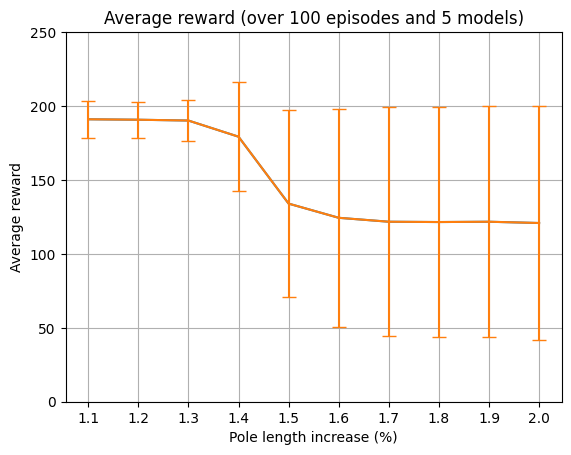

In [44]:
fig = plt.figure()
plt.plot(percentages, mean_avgs)
plt.errorbar(percentages, mean_avgs, std_dev_avgs, capsize=5)
plt.ylim(0, 250)
plt.grid(True)
plt.xlabel("Pole length increase (%)")
plt.xticks(percentages)
plt.ylabel("Average reward")
plt.title("Average reward (over 100 episodes and 5 models)")
plt.savefig("figs/BPDQRNN_650eps_5models_evaluation.png", dpi=300)

### Evaluate BP model on modified environment

In [11]:
modified_env_eval_rewards = []

for i, w in enumerate(weights):
    print('Run {:02d} ...'.format(i), end='')
    policy_net = RNetwork(4, 64, 2, 5).to(device)
    policy_net.loadWeights(w)

    rewards = evaluate_BP_policy(policy_net, modified_env, n_evaluations, evaluation_seeds)
    modified_env_eval_rewards.append(rewards)
    
    print(eraser*3 + '-> Avg reward: {:7.2f}'.format(np.mean(rewards)))

Run 00 -> Avg reward:  169.54
Run 01 -> Avg reward:  193.07
Run 02 -> Avg reward:  199.97


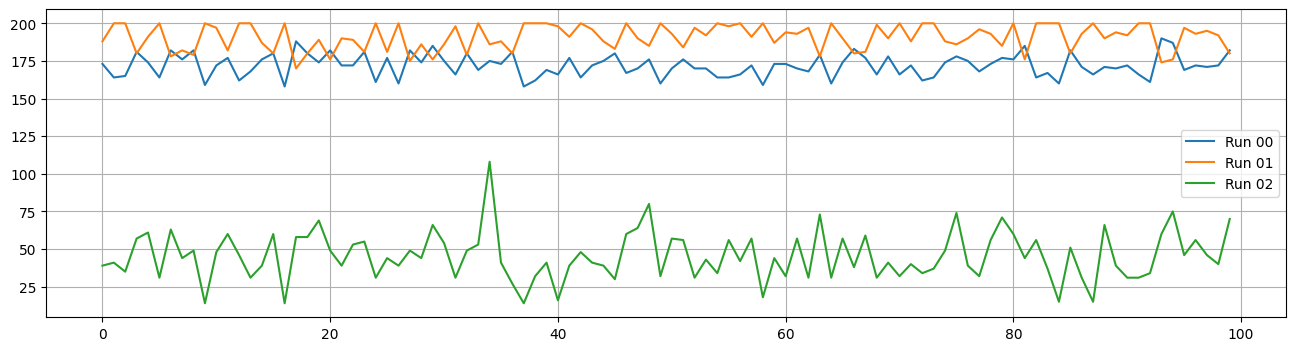

In [14]:
plt.figure(figsize=(16, 4))

for i, meer in enumerate(modified_env_eval_rewards):
    plt.plot(meer, label='Run {:02d}'.format(i))

plt.legend()
plt.grid()
plt.show()

### RSTDP Adaptation

In [14]:
rstdp_adaptation_rewards = []
adapted_weights_collection = []

for i, w in enumerate(weights):
    w_plus = deepcopy(w[0][1])
    w_minus = deepcopy(w[0][1])
    w_plus[w_plus < 0] = 0
    w_minus[w_minus > 0] = 0
    A_plus = torch.mean(w_plus)
    A_minus = torch.abs(torch.mean(w_minus))
    
    policy_net = RSTDPNet(alpha, beta, threshold, architecture, simulation_time, w, 
                                  tau, tau_e, A_plus, A_minus, C, 
                                  device=device, dtype=dtype)
    
    adapted_weights, rewards = rstdp_train_cartpole(policy_net, modified_env, max_reward, rstdp_episodes, 
                                                 n_evaluations, max_steps, rstdp_seeds, evaluation_seeds)
    
    rstdp_adaptation_rewards.append(rewards)
    adapted_weights_collection.append(adapted_weights)
    
adapted_weights_collection = [(list(aw.values()), []) for aw in adapted_weights_collection]

KeyboardInterrupt: 

### Evaluate adapted models on modified environment

In [15]:
adapted_eval_rewards = []

for i, w in enumerate(adapted_weights_collection):
    print('Run {:02d} ...'.format(i), end='')
    policy_net = RSTDPNet(alpha, beta, threshold, architecture, simulation_time, w,
                                  device=device, dtype=dtype)
    rewards = evaluate_policy(policy_net, modified_env, n_evaluations, evaluation_seeds)
    adapted_eval_rewards.append(rewards)
    print(eraser*3 + '-> Avg reward: {:7.2f}'.format(np.mean(rewards)))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


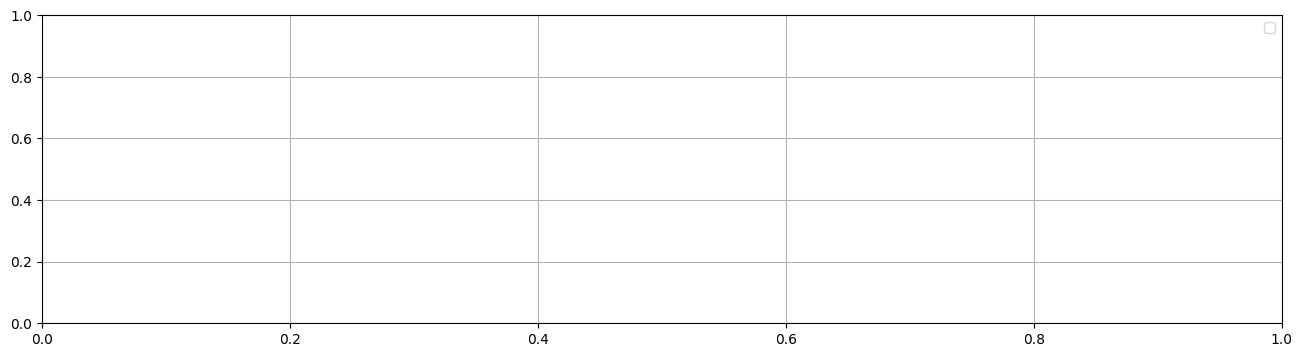

In [16]:
plt.figure(figsize=(16, 4))

for i, aer in enumerate(adapted_eval_rewards):
    plt.plot(aer, label='Run {:02d}'.format(i))

plt.legend()
plt.grid()
plt.show()